## Using values & k-nn weights

Refs:  
- https://darribas.org/gds_course/content/bG/lab_G.html
- https://geographicdata.science/book/notebooks/00_toc.html
- https://geodacenter.github.io/documentation.html

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from pysal.lib import weights
from libpysal.weights import w_union, w_difference, w_subset
import networkx as nx
import h3
from scipy.stats import gmean
from palettable.tableau import Tableau_10
import folium

from functools import partial
from pathlib import Path
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, pairwise_distances
# from fastcore.xtras import L

## Data loading

In [ ]:
fname = Path.home() / 'pro/data/maris/maris-seawater-lamer-2023-07-25.csv'
df = pd.read_csv(fname); df.shape

(29419, 13)

In [ ]:
# Filtering out North Atlantic Ocean
df = df[df['area_name'] != 'North Atlantic Ocean']
df['begperiod'] = pd.to_datetime(df['begperiod'])

In [ ]:
df.head()

smp_id        lat       lon  area_name  area_id  depth  profile_id  \
2724    5454  58.000000  0.000000  North Sea     2350    3.0         NaN   
2725    6118  56.000000  0.000000  North Sea     2350    3.0         NaN   
2726    9204  52.452778  1.818889  North Sea     2350    0.0         NaN   
2727    9745  51.741111  0.883611  North Sea     2350    0.0         NaN   
2728   15487  59.500000 -2.000000  North Sea     2350    3.0         NaN   

      begperiod nusymbol   unit  activity  uncertainty  ref_id  
2724 1973-06-29    137Cs  Bq/m3     25.90          NaN      84  
2725 1973-10-15    137Cs  Bq/m3     70.67          NaN      84  
2726 1982-06-09    137Cs  Bq/m3    129.77         1.43      84  
2727 1980-03-06    137Cs  Bq/m3    118.58         0.59      84  
2728 1988-02-20    137Cs  Bq/m3     22.13         0.69      84

### Select

In [ ]:
# df = df[df.lon > -20]

## Discretize

In [ ]:
print('depth range:\t', df['depth'].min(), ' - ', df['depth'].max())
print('time range:\t', df['begperiod'].min(), ' - ', df['begperiod'].max())

depth range:	 0.0  -  100.0
time range:	 1961-02-03 00:00:00  -  2018-02-15 09:00:00


In [ ]:
bins_depth = [0, 50, 101]
# bin_dates = [pd.to_datetime(d) 
#              for d in ['1961-01-01', '1979-01-01', '1986-01-01', '2011-01-01', '2019-01-01']]
bin_dates = [pd.to_datetime(d) 
             for d in ['1961-01-01', '1979-01-01', '1986-01-01', '2000-01-01',
                       '2005-01-01', '2011-01-01', '2015-01-01', '2019-01-01']]

# Alternatively by quantiles
# bin_dates = df['begperiod'].quantile([i/10 for i in range(11)]).values; bin_dates


In [ ]:
df['depth_bin'] = pd.cut(df['depth'], bins=bins_depth, right=False, labels=range(len(bins_depth)-1))
df['date_bin'] = pd.cut(df['begperiod'], bins=bin_dates, right=False, labels=range(len(bin_dates)-1))

In [ ]:
#df['date_bin'].value_counts()

In [ ]:
dim = 1
profile_tmp = (
    np.zeros((len(bin_dates)-1 )) if (dim == 1) 
    else np.zeros((len(bins_depth)-1, len(bin_dates)-1 )))

profile_tmp

array([0., 0., 0., 0., 0., 0., 0.])

## H3 encoding

In [ ]:
# https://uber.github.io/h3-py/api_reference
# https://h3geo.org/docs/quickstart
def to_h3(row, resolution=1, lat_col='lat', lon_col='lon'): 
    return h3.latlng_to_cell(row[lat_col], row[lon_col], resolution)

In [ ]:
resolution = 3
df['h3_idx'] = df.apply(partial(to_h3, resolution=resolution), axis=1)

In [ ]:
df.head()

smp_id        lat       lon  area_name  area_id  depth  profile_id  \
2724    5454  58.000000  0.000000  North Sea     2350    3.0         NaN   
2725    6118  56.000000  0.000000  North Sea     2350    3.0         NaN   
2726    9204  52.452778  1.818889  North Sea     2350    0.0         NaN   
2727    9745  51.741111  0.883611  North Sea     2350    0.0         NaN   
2728   15487  59.500000 -2.000000  North Sea     2350    3.0         NaN   

      begperiod nusymbol   unit  activity  uncertainty  ref_id depth_bin  \
2724 1973-06-29    137Cs  Bq/m3     25.90          NaN      84         0   
2725 1973-10-15    137Cs  Bq/m3     70.67          NaN      84         0   
2726 1982-06-09    137Cs  Bq/m3    129.77         1.43      84         0   
2727 1980-03-06    137Cs  Bq/m3    118.58         0.59      84         0   
2728 1988-02-20    137Cs  Bq/m3     22.13         0.69      84         0   

     date_bin           h3_idx  
2724        0  8309b4fffffffff  
2725        0  831975fffffffff  
2726        1  831941fffffffff  
2727        1  83194efffffffff  
2728        2  83192cfffffffff

In [ ]:
df['date_bin'] = df['date_bin'].cat.codes; df.head()

smp_id        lat       lon  area_name  area_id  depth  profile_id  \
2724    5454  58.000000  0.000000  North Sea     2350    3.0         NaN   
2725    6118  56.000000  0.000000  North Sea     2350    3.0         NaN   
2726    9204  52.452778  1.818889  North Sea     2350    0.0         NaN   
2727    9745  51.741111  0.883611  North Sea     2350    0.0         NaN   
2728   15487  59.500000 -2.000000  North Sea     2350    3.0         NaN   

      begperiod nusymbol   unit  activity  uncertainty  ref_id depth_bin  \
2724 1973-06-29    137Cs  Bq/m3     25.90          NaN      84         0   
2725 1973-10-15    137Cs  Bq/m3     70.67          NaN      84         0   
2726 1982-06-09    137Cs  Bq/m3    129.77         1.43      84         0   
2727 1980-03-06    137Cs  Bq/m3    118.58         0.59      84         0   
2728 1988-02-20    137Cs  Bq/m3     22.13         0.69      84         0   

      date_bin           h3_idx  
2724         0  8309b4fffffffff  
2725         0  831975fffffffff  
2726         1  831941fffffffff  
2727         1  83194efffffffff  
2728         2  83192cfffffffff

In [ ]:
df_hex1 = df[df['h3_idx'] == '8309b4fffffffff'];
df_hex1.head()

smp_id        lat       lon  area_name  area_id  depth  profile_id  \
2724    5454  58.000000  0.000000  North Sea     2350    3.0         NaN   
2767   12097  57.495000  0.003333  North Sea     2350    3.0         NaN   
2910   12095  58.001667  0.001667  North Sea     2350    3.0         NaN   
2911   13068  58.000000  0.000000  North Sea     2350    3.0         NaN   
3102   13525  57.500000 -0.040000  North Sea     2350    3.0         NaN   

      begperiod nusymbol   unit  activity  uncertainty  ref_id depth_bin  \
2724 1973-06-29    137Cs  Bq/m3     25.90          NaN      84         0   
2767 1981-08-04    137Cs  Bq/m3     76.09         0.76      84         0   
2910 1981-08-03    137Cs  Bq/m3     70.40         0.63      84         0   
2911 1983-10-03    137Cs  Bq/m3     35.24         1.34      84         0   
3102 1984-11-18    137Cs  Bq/m3     27.13         0.68      84         0   

      date_bin           h3_idx  
2724         0  8309b4fffffffff  
2767         1  8309b4fffffffff  
2910         1  8309b4fffffffff  
2911         1  8309b4fffffffff  
3102         1  8309b4fffffffff

In [ ]:
profiles = []
if dim == 1:
    for name, data in df.groupby('h3_idx'):
        hex_profile = np.copy(profile_tmp)
        df_agg = data[['date_bin', 'activity']].groupby(['date_bin']).agg(gmean).dropna()
        idxs = df_agg.index.values
        hex_profile[idxs] = df_agg.values.squeeze()
        profiles.append(hex_profile)
else:
    for name, data in df.groupby('h3_idx'):
        hex_profile = np.copy(profile_tmp)
        df_agg = data[['depth_bin', 'date_bin', 'activity']].groupby(['depth_bin', 'date_bin']).agg(gmean).dropna()
        idxs = np.array([[a, b] for a,b in df_agg.index.values])
        hex_profile[idxs[:, 0], idxs[:, 1]] = df_agg.values.reshape(-1)
        profiles.append(hex_profile.flatten())
        
profiles = pd.DataFrame(np.array(profiles)) 

In [ ]:
profiles

0    1           2         3          4          5          6
0     0.00  0.0  201.595463   0.00000  46.894853  30.077477  23.941178
1     0.00  8.3  205.297582  68.93362  44.816021  34.241713  25.907532
2     0.00  0.0  164.604915   0.00000   0.000000   0.000000   0.000000
3     0.00  0.0  124.963995   0.00000   0.000000   0.000000   0.000000
4     0.00  0.0  447.911822   0.00000   0.000000   0.000000   0.000000
..     ...  ...         ...       ...        ...        ...        ...
204   4.07  0.0    0.000000   0.00000   0.000000   0.000000   0.000000
205   0.00  0.0    1.950000   0.00000   0.000000   0.000000   0.000000
206   2.96  0.0    0.000000   0.00000   0.000000   0.000000   0.000000
207  12.95  0.0    0.000000   0.00000   0.000000   0.000000   0.000000
208   8.51  0.0    0.000000   0.00000   0.000000   0.000000   0.000000

[209 rows x 7 columns]

In [ ]:
df_hex = df.groupby('h3_idx')['activity'].agg(gmean).reset_index(); df_hex


h3_idx    activity
0    830880fffffffff  118.808045
1    830881fffffffff  123.215262
2    830882fffffffff  164.604915
3    830883fffffffff  124.963995
4    830888fffffffff  447.911822
..               ...         ...
204  836703fffffffff    4.070000
205  836709fffffffff    1.950000
206  83672cfffffffff    2.960000
207  836761fffffffff   12.950000
208  836773fffffffff    8.510000

[209 rows x 2 columns]

In [ ]:
def h3_to_polygon(h3_idx):
    h3_idx_geojson = h3.cell_to_boundary(h3_idx, geo_json=True)
    polygon = Polygon(h3_idx_geojson)
    return polygon

In [ ]:
df_hex['geometry'] = df_hex['h3_idx'].apply(h3_to_polygon)

In [ ]:
df_hex.head()

h3_idx    activity  \
0  830880fffffffff  118.808045   
1  830881fffffffff  123.215262   
2  830882fffffffff  164.604915   
3  830883fffffffff  124.963995   
4  830888fffffffff  447.911822   

                                            geometry  
0  POLYGON ((17.250449424717242 60.41134486276625...  
1  POLYGON ((18.25333679056859 61.16074546372224,...  
2  POLYGON ((18.261052750874455 59.6986232667684,...  
3  POLYGON ((19.266387181080947 60.45217645324445...  
4  POLYGON ((21.005482736763796 61.59764998811295...

## To Geopandas

In [ ]:
gdf = gpd.GeoDataFrame(df_hex, geometry='geometry', crs="EPSG:4326")

In [ ]:
gdf.head()

h3_idx    activity  \
0  830880fffffffff  118.808045   
1  830881fffffffff  123.215262   
2  830882fffffffff  164.604915   
3  830883fffffffff  124.963995   
4  830888fffffffff  447.911822   

                                            geometry  
0  POLYGON ((17.25045 60.41134, 17.26259 59.92157...  
1  POLYGON ((18.25334 61.16075, 18.25596 60.67859...  
2  POLYGON ((18.26105 59.69862, 18.26353 59.20079...  
3  POLYGON ((19.26639 60.45218, 19.25929 59.96206...  
4  POLYGON ((21.00548 61.59765, 21.95272 61.39610...

In [ ]:
# gdf = gdf.to_crs(3857)

In [ ]:
np.std(np.array([0]))

0.0

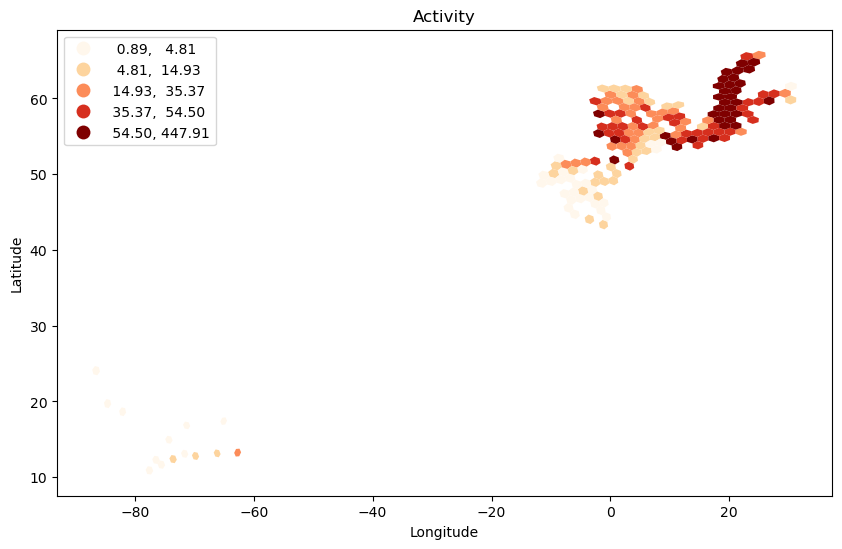

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Set the x and y-axis limits
# x_min, x_max = -15, 35
# y_min, y_max = 40, 70
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)


# # Logarithmic colormap
# cmap = 'plasma'  # Choose the colormap of your choice
# norm = colors.LogNorm()  # Use LogNorm for logarithmic scaling

# Plot the GeoDataFrame on the specified Axes
gdf.plot(ax=ax, column='activity', cmap='OrRd', scheme='quantiles', 
         legend=True, legend_kwds={"loc": 2})

# Customize the plot if needed
ax.set_title("Activity")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");

## Regionalization

### Utils

In [ ]:
def get_cpts(w):
    G = nx.Graph()
    for node, neighbors in w.neighbors.items():
        G.add_node(node)  
        G.add_edges_from((node, neighbor) for neighbor in neighbors) 
    return [list(c) for c in nx.connected_components(G)]

### Spatial weights

#### Contiguity

In [ ]:
wq = weights.contiguity.Queen.from_dataframe(gdf)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 13 islands with ids: 88, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208.
  warnings.warn(message)


In [ ]:
#wq.islands

#### K-nn

In [ ]:
wknn = weights.distance.KNN.from_dataframe(gdf, k=6)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


#### Merge (where islands)

In [ ]:
def merge(wq, wknn):
    neighbors = wq.neighbors.copy()
    for i in wq.islands:
        neighbors[i] = list(wknn[i].keys())
    return weights.W(neighbors)

w = merge(wq, wknn)

#### Get disconneceted components

In [ ]:
cpts = get_cpts(w)
print('# of components: ', len(cpts))

# of components:  2


## Clustering

In [ ]:
cpt = 0
max_clusters = 8

for n in range(2, max_clusters+1):
    model = AgglomerativeClustering(
        linkage="ward", 
        connectivity=w_subset(w, cpts[cpt]).sparse, 
        n_clusters=n
    )
    model.fit(profiles.iloc[cpts[cpt],:])
    score = calinski_harabasz_score(profiles.iloc[cpts[cpt],:], model.labels_)
    print(f'# clusters: {n} | score: {score}')

# clusters: 2 | score: 663.8024925408536
# clusters: 3 | score: 869.6480931421258
# clusters: 4 | score: 767.3979799358995
# clusters: 5 | score: 772.079463956081
# clusters: 6 | score: 827.0075170930078
# clusters: 7 | score: 918.9833257212464
# clusters: 8 | score: 1026.452973784063


In [ ]:
# Define your custom distance metric function
def custom_distance(x, y):
    print("x: ", x, '\n')
    print("y: ", y, '\n')
    # Implement your custom distance calculation here
    return np.sum((x - y)**2)


In [ ]:
pairwise_distances(X

SyntaxError: incomplete input (1981552511.py, line 1)

In [ ]:
X = profiles.iloc[cpts[cpt],:].to_numpy(); X.shape

(195, 7)

In [ ]:
pairwise_distances(X, metric=custom_distance).shape

x:  [  0.           0.         201.59546296   0.          46.89485291
  30.07747713  23.94117792] 

y:  [  0.           8.3        205.29758173  68.93362038  44.81602142
  34.24171285  25.90753172] 

x:  [  0.           0.         201.59546296   0.          46.89485291
  30.07747713  23.94117792] 

y:  [  0.           0.         164.60491486   0.           0.
   0.           0.        ] 

x:  [  0.           0.         201.59546296   0.          46.89485291
  30.07747713  23.94117792] 

y:  [  0.           0.         124.96399481   0.           0.
   0.           0.        ] 

x:  [  0.           0.         201.59546296   0.          46.89485291
  30.07747713  23.94117792] 

y:  [  0.           0.         447.91182168   0.           0.
   0.           0.        ] 

x:  [  0.           0.         201.59546296   0.          46.89485291
  30.07747713  23.94117792] 

y:  [  0.          0.        178.5361931   0.          0.          0.
   0.       ] 

x:  [  0.           0.         201.595

(195, 195)

In [ ]:
n_clusters = 3 # chosen # of clusters

model = AgglomerativeClustering(
    # linkage="ward", 
    linkage='ward', 
    connectivity=w_subset(w, cpts[cpt]).sparse, 
    # affinity=custom_distance,
    n_clusters=n_clusters
)
# Fit algorithm to the data
model.fit(profiles.iloc[cpts[cpt],:])
# model.labels_

RecursionError: maximum recursion depth exceeded while calling a Python object

RecursionError: maximum recursion depth exceeded

RecursionError: maximum recursion depth exceeded

### Visualize

In [ ]:
gdf_sub = gdf.iloc[cpts[cpt],:].copy()
gdf_sub['cluster'] = model.labels_

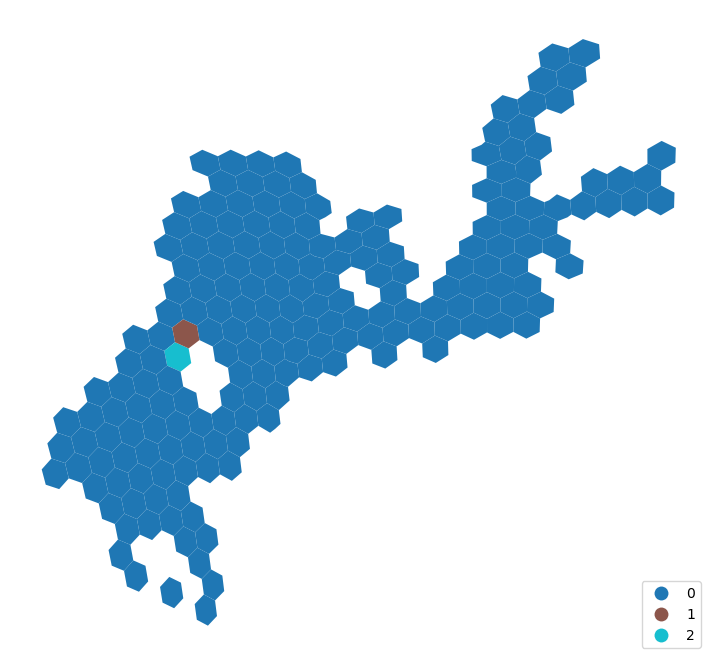

In [ ]:

# Set up figure and ax
fig, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf_sub.plot(
    column="cluster",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
    legend_kwds={'loc': 'lower right'}
)

# Remove axis
ax.set_axis_off()

# Display the map
plt.show()

In [ ]:
def style_function(feature, n_clusters, prop_name='cluster', palette=Tableau_10):
    attribute_value = feature['properties'][prop_name]
    return {'fillColor': palette.hex_colors[attribute_value], 
            'color': 'none', 
            'fillOpacity': 0.7}

In [ ]:
gdf = gdf_sub.to_crs(epsg=4326)

# Create a Folium map centered at a specific location
m = folium.Map(location=[gdf_sub.centroid.y.mean(), gdf_sub.centroid.x.mean()], zoom_start=3)

# Convert the GeoDataFrame to GeoJSON format
geojson_data = gdf_sub.to_json()

# Create a GeoJson layer and add it to the map
folium.GeoJson(geojson_data, style_function=partial(style_function, n_clusters=n_clusters)).add_to(m)

m

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_65761/2702531757.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf_sub.centroid.y.mean(), gdf_sub.centroid.x.mean()], zoom_start=3)


In [ ]:
df_cpt = profiles.iloc[cpts[cpt],:].copy()

In [ ]:
df_cpt['cluster'] = model.labels_; profiles_cpt.head()
# profiles_cpt.set_index('cluster', inplace=True)

0    1           2         3          4          5          6  \
cluster                                                                    
0        0.0  0.0  201.595463   0.00000  46.894853  30.077477  23.941178   
0        0.0  8.3  205.297582  68.93362  44.816021  34.241713  25.907532   
0        0.0  0.0  164.604915   0.00000   0.000000   0.000000   0.000000   
0        0.0  0.0  124.963995   0.00000   0.000000   0.000000   0.000000   
0        0.0  0.0  447.911822   0.00000   0.000000   0.000000   0.000000   

         cluster  
cluster           
0              0  
0              0  
0              0  
0              0  
0              0

In [ ]:
import seaborn as sns

In [ ]:
df_cpt = pd.melt(df_cpt, id_vars=['cluster'], 
                 var_name='date_bin', value_name='value'); df_cpt.head()

cluster date_bin  value
0        0        0    0.0
1        0        0    0.0
2        0        0    0.0
3        0        0    0.0
4        0        0    0.0

['1961-01-01',
 '1979-01-01',
 '1986-01-01',
 '2000-01-01',
 '2005-01-01',
 '2011-01-01',
 '2015-01-01',
 '2019-01-01']

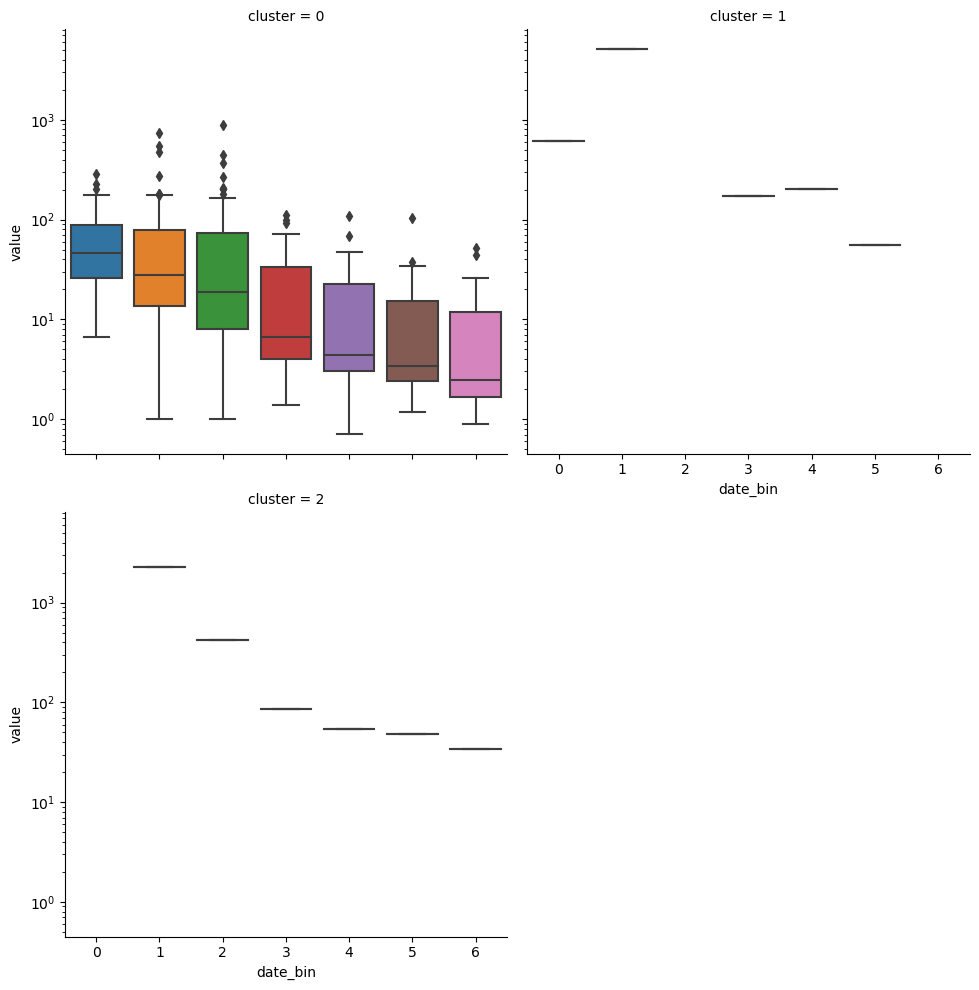

In [ ]:
sns.catplot(
    data=df_cpt[df_cpt['value'] != 0], x='date_bin', y='value',
    col='cluster', kind='box', col_wrap=2
)
plt.yscale('log')

['1961-01-01', '1979-01-01', '1986-01-01', '2000-01-01', '2005-01-01', '2011-01-01', '2015-01-01', '2019-01-01']

## Legacy code

In [ ]:
rows, cols = profile_tmp.shape
profiles_np = profiles.to_numpy().reshape((-1, rows, cols)); profiles_np.shape

(201, 2, 10)

cluster numb:  0


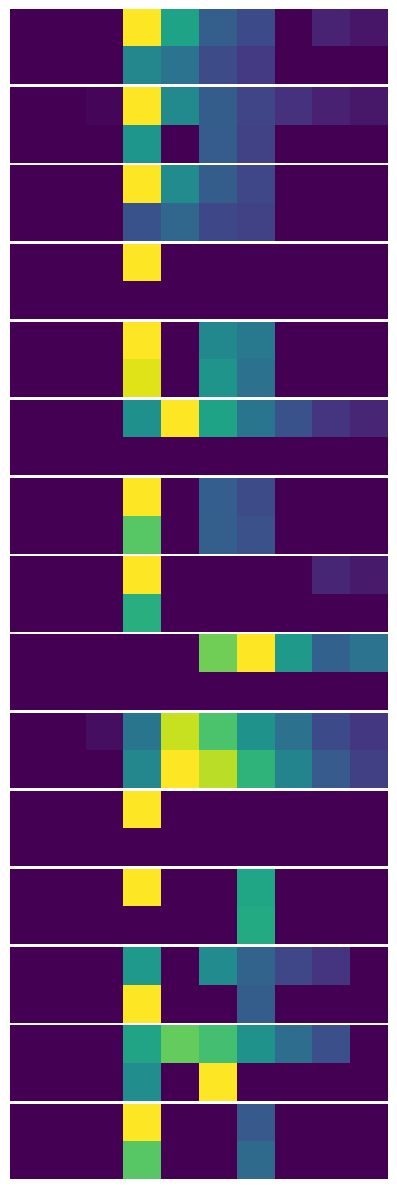

In [ ]:
# model.labels_
# TODO
#   - add common color palette
#   - alternative line plot if 1D
label = 0
idxs = np.where(model.labels_ == label)
profile_class = profiles_np[idxs,:].squeeze()

num_plots = profile_class.shape[0]

print('cluster numb: ', label)
# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(6, 12))

# Loop through the subplots and plot the data
for i, ax in enumerate(axes):
    ax.imshow(profile_class[i,:], cmap='viridis') 
    ax.set_axis_off()

plt.tight_layout(h_pad=0.2)
